**Sentiment Analysis of IMDB Movie Reviews**

**Problem Statement:**

In this, we have to predict the number of positive and negative reviews based on sentiments by using different classification models.

**Import necessary libraries**

In [2]:
# Load the libraries
import numpy as np
import pandas as pd
# import seaborn as sns  # Uncomment if you're doing visualizations
# import matplotlib.pyplot as plt  # Uncomment if you're doing visualizations
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
# from nltk.stem.porter import PorterStemmer  # Consider removing if you'll use lemmatization
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
# Importing WordNetLemmatizer once
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
!pip install textblob
from textblob import TextBlob
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.tokenize import ToktokTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import wordnet
from nltk import pos_tag



from sklearn.metrics import accuracy_score, classification_report


import os
import warnings
warnings.filterwarnings('ignore')

# Preparing nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')  # For POS tagging, required for lemmatization

# Checking the input directory (optional, based on whether you need to list input files)
# print(os.listdir("../input"))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mdsha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mdsha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mdsha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mdsha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

**Import the training dataset**

In [3]:
#importing the training data
imdb_data=pd.read_csv('IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)


(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


**Exploratery data analysis**

In [4]:
#Summary of the dataset
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


**Sentiment count**

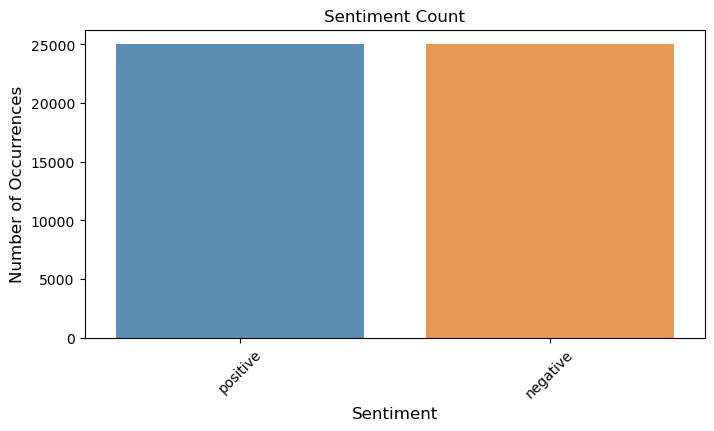

In [5]:
##ssuming sentiment_count has already been calculated
sentiment_count = imdb_data['sentiment'].value_counts()

# Visualizing the sentiment count
plt.figure(figsize=(8, 4))
sns.barplot(x=sentiment_count.index, y=sentiment_count.values, alpha=0.8)
plt.title('Sentiment Count')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(rotation=45)  # Rotate labels to ensure they fit well
plt.show()


We can see that the dataset is balanced.

**Spliting the training dataset**

In [6]:

# Reduce the dataset to a manageable subset size with stratified sampling
_, data_subset = train_test_split(
    imdb_data,
    stratify=imdb_data['sentiment'],
    test_size=7500 / len(imdb_data),  # Adjust this to change the subset size
    random_state=42
)

# Ensure a stratified split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_subset['review'],
    data_subset['sentiment'],
    test_size=0.2,  # Keeping an 80-20 split for training and testing
    random_state=42,
    stratify=data_subset['sentiment']
)

print(f"Training set size: {X_train.shape[0]} reviews")
print(f"Testing set size: {X_test.shape[0]} reviews")


Training set size: 6000 reviews
Testing set size: 1500 reviews


**Text normalization**

In [7]:


# Download necessary NLTK data (if not already done)


# Tokenizer initialization
tokenizer = ToktokTokenizer()

# Stopword list setup
stopword_list = nltk.corpus.stopwords.words('english')

# Enhanced preprocessing function including stopword removal
def remove_stopwords(text, is_lower_case=False, stopwords=stopword_list):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]

    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]

    filtered_text = ' '.join(filtered_tokens)
    return filtered_text




**Removing html strips and noise text**

In [8]:

# Function to remove HTML content
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Function to remove content within square brackets
def remove_between_square_brackets(text):
    return re.sub(r'\[[^]]*\]', '', text)

# Function to remove special characters and digits
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-Z\s]' if not remove_digits else r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

# Function to denoise text by applying all the above
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    return text

# Apply the denoising function on the review column
imdb_data['review'] = imdb_data['review'].apply(denoise_text)


**Text stemming
**

In [9]:
lemmatizer = WordNetLemmatizer()

# Helper function to convert nltk tag to wordnet tag
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Function for lemmatizing text with POS tagging
def lemmatize_text(text):
    word_tokens = word_tokenize(text)
    pos_tagged_tokens = pos_tag(word_tokens)
    lemmatized_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag) or wordnet.NOUN)
        for word, pos_tag in pos_tagged_tokens
    ]
    return ' '.join(lemmatized_words)

# Apply the lemmatization function on the review column
imdb_data['review'] = imdb_data['review'].apply(lemmatize_text)


**Normalized train reviews**

In [10]:


# Assuming imdb_data has already been preprocessed
X = imdb_data['review']
y = imdb_data['sentiment']

# Stratified split to ensure the training and testing sets have similar sentiment distributions
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # Assuming an 80-20 split for training and testing
    random_state=42,  # Ensures reproducibility of your splits
    stratify=y  # Ensures train and test sets have similar distributions of sentiment classes
)

# Displaying the first review from the training and testing datasets
print("First review from training set:", X_train.iloc[0])
print("A review from the testing set:", X_test.iloc[-1])  # Example; could be any index


First review from training set: I catch this little gem totally by accident back in 1980 or 81 I be at a revival theatre to see two old silly scifi movie The theatre be pack full and with no warning they show a bunch of scifi short spoof to get u in the mood Most be somewhat amuse but THIS come on and within second the audience be in hysteric The big laugh come when they show Princess Laia have huge cinnamon bun instead of hair on her head She look at the camera give a grim smile and nod That make it even funnier You get ta see Chewabacca play by what look like a Muppet It be extremely silly and stupidbut I couldnt stop laugh Most of the dialogue be drown out because of all the laughter Also if you know Star Wars pretty well it even funnierthey deliberately poke fun at some of the dialogue This REALLY work with an audience A definite 10
A review from the testing set: Leon Errol handle his double role of Uncle Matt Lindsay and Lord Basil Epping superbly but I have trouble like the Mexic

**Bags of words model **

For Features Extraction


In [11]:


# CountVectorizer for bag of words
cv = CountVectorizer(min_df=5, max_df=0.9, binary=False, ngram_range=(1, 3))

# Transformed train reviews
cv_train_reviews = cv.fit_transform(X_train)

# Transformed test reviews
cv_test_reviews = cv.transform(X_test)

print('BOW_cv_train:', cv_train_reviews.shape)
print('BOW_cv_test:', cv_test_reviews.shape)

# To get feature names
vocab = cv.get_feature_names_out()  # Updated method for getting feature names


BOW_cv_train: (40000, 359586)
BOW_cv_test: (10000, 359586)


**Term Frequency-Inverse Document Frequency model (TFIDF)**

It is used to convert text documents to  matrix of  tfidf features.

In [12]:


# TfidfVectorizer for feature extraction
tv = TfidfVectorizer(min_df=5, max_df=0.9, use_idf=True, ngram_range=(1, 3))

# Transformed train reviews
tv_train_reviews = tv.fit_transform(X_train)  # Use X_train from the stratified split

# Transformed test reviews
tv_test_reviews = tv.transform(X_test)  # Use X_test from the stratified split

print('Tfidf_train:', tv_train_reviews.shape)
print('Tfidf_test:', tv_test_reviews.shape)


Tfidf_train: (40000, 359586)
Tfidf_test: (10000, 359586)


**Labeling the sentiment text**

In [13]:


# Initialize the LabelBinarizer
lb = LabelBinarizer()

# Transforming sentiment data for both training and testing sets
y_train_binarized = lb.fit_transform(y_train)
y_test_binarized = lb.transform(y_test)

print('y_train_binarized shape:', y_train_binarized.shape)
print('y_test_binarized shape:', y_test_binarized.shape)


y_train_binarized shape: (40000, 1)
y_test_binarized shape: (10000, 1)


**Split the sentiment tdata**

In [14]:
# y_train_binarized and y_test_binarized are already defined as shown previously

# These variables now correctly represent your sentiment labels for training and testing
train_sentiments = y_train_binarized
test_sentiments = y_test_binarized

# Displaying the shapes of the sentiment arrays to confirm the split
print('Train sentiments shape:', train_sentiments.shape)
print('Test sentiments shape:', test_sentiments.shape)

# Optional: Displaying the first few sentiment labels from the training and testing sets
print('First few training sentiments:', train_sentiments[:5])
print('First few testing sentiments:', test_sentiments[:5])


Train sentiments shape: (40000, 1)
Test sentiments shape: (10000, 1)
First few training sentiments: [[1]
 [0]
 [0]
 [0]
 [0]]
First few testing sentiments: [[0]
 [0]
 [1]
 [0]
 [0]]


###Hybrid Model

In [15]:

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
random_forest_model = RandomForestClassifier(random_state=42)
svm_model = SVC(random_state=42, probability=True)
logistic_regression_model = LogisticRegression(random_state=42, max_iter=50)  # Increase max_iter if needed

hybrid_model = VotingClassifier(estimators=[
    ('rf', random_forest_model),
    ('svm', svm_model),
    ('lr', logistic_regression_model)],
    voting='soft')

#Training Model
hybrid_model.fit(cv_train_reviews, train_sentiments.ravel())


# Making predictions
hybrid_predictions = hybrid_model.predict(cv_test_reviews)

# Evaluating the model
print("Hybrid Model Accuracy:", accuracy_score(test_sentiments, hybrid_predictions))
print("\nHybrid Model Classification Report:\n", classification_report(test_sentiments, hybrid_predictions))


Hybrid Model Accuracy: 0.9078

Hybrid Model Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91      5000
           1       0.90      0.91      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



###Saving our Model

In [17]:
import pickle

# Saving trained 'hybrid_model' 
with open('hybrid_model.pkl', 'wb') as file:
    pickle.dump(hybrid_model, file)


### Random Forest Model


In [ ]:

rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(cv_train_reviews, train_sentiments.ravel())

rf_predictions = rf_model.predict(cv_test_reviews)
print("Random Forest Accuracy:", accuracy_score(test_sentiments, rf_predictions))
print("\nRandom Forest Classification Report:\n", classification_report(test_sentiments, rf_predictions))

### SVM MODEL

In [22]:
#svm_model = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True, random_state=42)

#svm_model.fit(cv_train_reviews, train_sentiments.ravel())
#svm_predictions = svm_model.predict(cv_test_reviews)
#print("SVM Accuracy:", accuracy_score(test_sentiments, svm_predictions))
#print("\nSVM Classification Report:\n", classification_report(test_sentiments, svm_predictions))

### Logistic Regression Model

In [ ]:
#lr_model = LogisticRegression(C=1.0, max_iter=1000, solver='liblinear', penalty='l2', random_state=42)
#lr_model.fit(cv_train_reviews, train_sentiments.ravel())
#lr_predictions = lr_model.predict(cv_test_reviews)
#print("Logistic Regression Accuracy:", accuracy_score(test_sentiments, lr_predictions))
#print("\nLogistic Regression Classification Report:\n", classification_report(test_sentiments, lr_predictions))

###Visualization using AUC and ROC

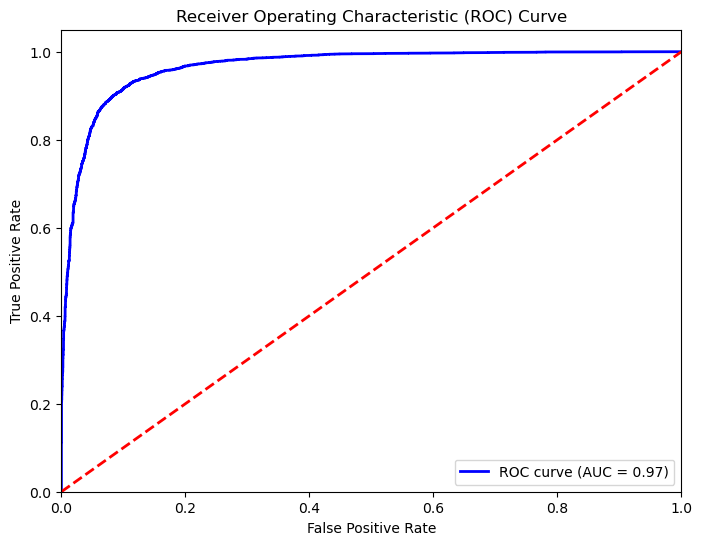

AUC: 0.96595552


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Step 1: Generate predictions and probabilities
hybrid_predictions = hybrid_model.predict(cv_test_reviews)
hybrid_probabilities = hybrid_model.predict_proba(cv_test_reviews)[:, 1]  # For ROC curve, we need probabilities for positive class


# Step 2: Plot the ROC curve
fpr, tpr, thresholds = roc_curve(test_sentiments, hybrid_probabilities, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("AUC:", roc_auc)
